In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import POD, DMD, ROM, DMDc
import matplotlib.pyplot as plt
import scipy.interpolate as si

**Import data**

In [2]:
pist_pressure = np.load("../DATA/Fsi_Results/pist_pressure.npy")
nnt = pist_pressure.shape[0]
fl_pressure = np.load("../DATA/Fsi_Results/fl_pressure.npy")
fl_rho_e = np.load("../DATA/Fsi_Results/fl_rho_e.npy")
fl_rho_v = np.load("../DATA/Fsi_Results/fl_rho_v.npy")
fl_velocity_end = np.load("../DATA/Fsi_Results/fl_velocity_end.npy")
fl_rho = np.load("../DATA/Fsi_Results/fl_rho.npy")
moving_mesh = np.load("../DATA/Fsi_Results/fl_moving_mesh.npy")
delta_t = np.load("../DATA/Fsi_Results/delta_t.npy")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho
sol_accel = np.load("../DATA/Fsi_Results/sol_accel.npy")
Ec = np.load("../DATA/Fsi_Results/Ec.npy")
Em = np.load("../DATA/Fsi_Results/Em.npy")
Ep = np.load("../DATA/Fsi_Results/Ep.npy")
Imp_fl = np.load("../DATA/Fsi_Results/Imp_fl.npy")

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1
L0 = 1
mass = 1000
rigid = 1e7
Ls0 = 1.2
Lse = Ls0 - 1e5 / rigid


## DMDc Reduction

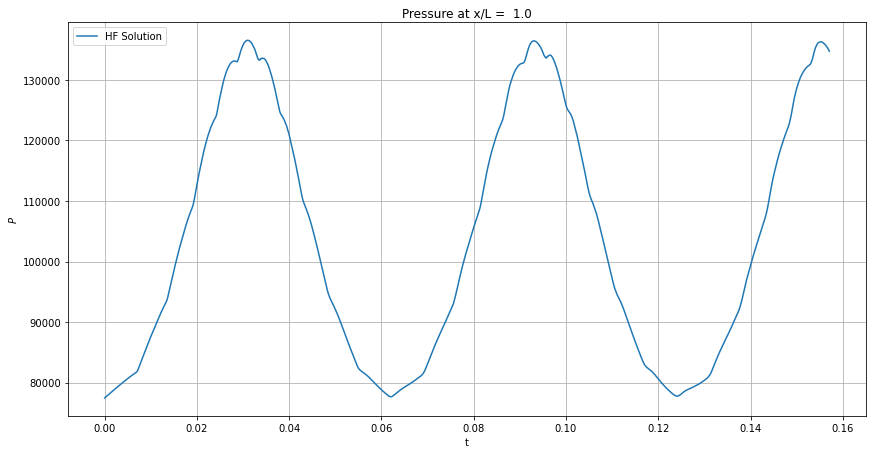

In [3]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))

plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

The HF solution captures 2.5 periods of the system, we will train the ROM on 1.75 periods and 200 points and the rest will be used for testing

**Interpolate to fixed time intervals**

In [4]:
# Choose number of equally spaced timesteps 
n_T = 2.5
n_snap = 280
frac = 1.75
ntt = int(n_snap /(frac/n_T))
dt = (t[-1] - t[0]) / (ntt - 1)

# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_fl_pressure = si.griddata(t, fl_pressure.T, target_t, method='nearest').T
target_fl_velocity = si.griddata(t, fl_velocity.T, target_t, method='nearest').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='nearest').T
target_sol_accel = si.griddata(t, sol_accel.T, target_t, method='nearest').T

**Probe data for training**

In [5]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = frac/n_T

# Training data (considering moving mesh)
XY_DATA = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)], 
                          target_fl_m_mesh[:, :int(ntt * Coeff)], target_sol_accel[:int(ntt * Coeff)][np.newaxis, :]))
X = XY_DATA[:, :-1]
Y = XY_DATA[:, 1::]

**DMDc reduction**

In [19]:
#Fixed control inputs:
u_input = np.ones((1, X.shape[1]))

# DMD
rank = 0
dmdc = DMDc()
dromc = ROM(dmdc)
dromc.decompose(X,  Y = Y, dt = dt, rank =rank, Y_input = u_input, opt_trunc=True)

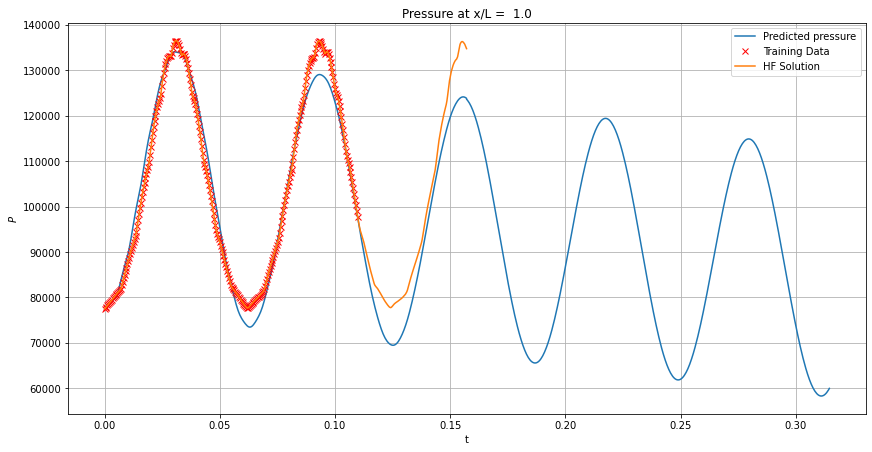

In [23]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1
satbilize_ = False

fig = plt.figure(figsize = (12, 6))
prediction_t = np.concatenate((target_t, target_t + target_t[-1]))


# Affine DMD prediction ----------------------------------
# --------- Prediction using the 
#predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], stabilize=satbilize_, fixed_input=True, u_input = u_input))
predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], stabilize=satbilize_, u_input = np.ones((1, prediction_t.shape[0]))))
prediction_t = np.concatenate((prediction_t, np.array([prediction_t[-1]+dt])))

# Post Processing
predicted_pressure = predicted_X[:nx, :]
predicted_mesh = predicted_X[2 * nx: 3*nx, :]


# Plotting results
plt.plot(prediction_t, predicted_pressure[-x_n, :], '-', label = "Predicted pressure")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_pressure[-x_n, :int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));